In [1]:
import sys
import os
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.utils import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

/Users/andreabioddo/Desktop/POLITO/LLM/progetto/LLM_Agent-Goal_Oriented_API_Alignement/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiments

In [2]:
SHOTS_NUMBER = ShotPromptingMode.FEW_SHOT
PREPROCESSING = True #stemming and lemmization for the evaluation
OUPUT_PATH = "output/"

os.makedirs(OUPUT_PATH, exist_ok=True)

#### Choose the project among the available ones

In [3]:
from groundtruth import GENOME, GESTAO_HOSPITAL
GROUNDTRUTH = GESTAO_HOSPITAL


### Description Generation

In [4]:
print("Description STARTING...")
description = generate_description(GROUNDTRUTH["link-readme"])
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='The project "GestaoHospital" is a hospital management system designed to create an API that organizes a public health system, specifically the Sistema Único de Saúde (SUS) in Brazil. The primary purpose of this system is to improve the efficiency of hospitals by facilitating better management of resources and patient care. \n\nIt aims to provide functionalities for registering hospitals, indicating the nearest facilities based on patient location, managing patient check-ins and check-outs, and overseeing bed availability. Additionally, users can manage the inventory of hospital products and maintain blood bank stocks, ensuring that healthcare facilities can respond effectively to the needs of the patients while preventing waste and optimizing resources.'


### Actors Extraction

In [5]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Hospital Administrators', description='Individuals responsible for managing hospital operations and resources.'), Actor(name='Healthcare Staff', description='Doctors, nurses, and other staff who manage patient care and check-ins/outs.'), Actor(name='Patients', description='Individuals receiving healthcare services in the hospital.'), Actor(name='Inventory Managers', description='Personnel overseeing the management of hospital products and blood bank stocks.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The actors defined seem to cover the main roles involved in the hospital management system, but the description could be improved by considering additional actors such as 'System Administrators' who may be responsible for maintaining the API and overall system, or 'External Users' who may be using the system to find nearest hospitals or access other public infor

### High Level Goals Extraction

In [ ]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

### Low Level Goals Extraction

In [ ]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

### APIs Extraction from Swagger

In [ ]:
print("API List STARTING...")
apiList = get_api_list_from_swagger(link=GROUNDTRUTH["swagger"])
print("API List DONE...")
print(apiList)

### APIs Mapping to Low Level Goals

In [ ]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

In [ ]:
print(mappings[0].low_level_goal.high_level_associated.name)

### Mapping Table

In [ ]:
import json

print_api_goal_mapping(mappings)
with open(f"{OUPUT_PATH}/final_mapping_{SHOTS_NUMBER}.txt", "w") as f:
    f.write(json.dumps(mappings, default=lambda o: o.__dict__, indent=4))

# Evaluation

### Evaluation: Extracted High Level Goals 

In [ ]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = GROUNDTRUTH["highLevelGoals"]

evaluator = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec, summary, best_f1 = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals, output_file=f"{OUPUT_PATH}/hl_{SHOTS_NUMBER}.txt", save_to_file=True)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)
print(f"Best F1 Score: {best_f1}")


### Evaluation: Extracted Low Level Goals 

In [ ]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = GROUNDTRUTH["lowLevelGoals"]

evaluator_low_level = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec, summary, best_f1 = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals, output_file=f"{OUPUT_PATH}/ll_{SHOTS_NUMBER}.txt", save_to_file=True)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)
print(f"Best F1 Score: {best_f1}")

### Evaluation: Extracted Actors 

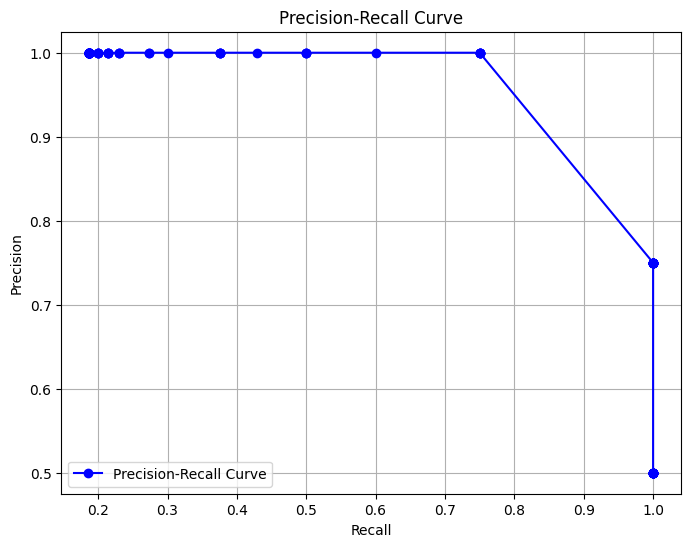

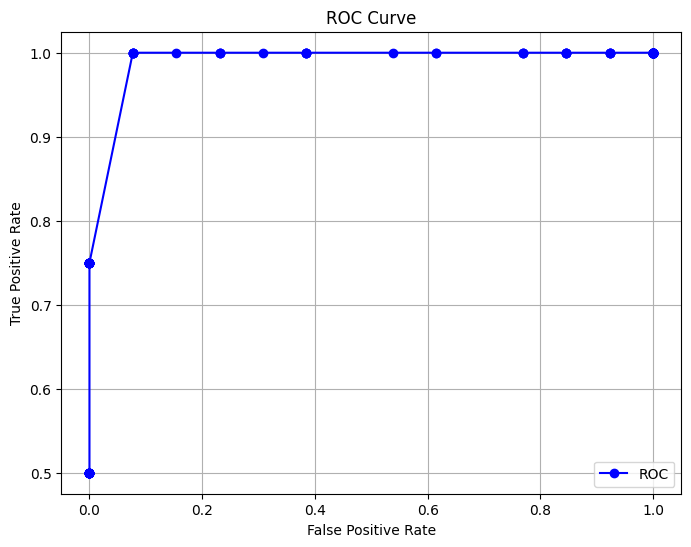

Actors ROC AUC: 0.9903846149807074
Actors Precision Recall Curve AUC: 0.46874999964062497
Best F1 Score: th: 0.6900000000000001, preciion: 0.7499999998125, recall: 0.9999999996666666, fpr: 0.07692307691715976, f1_score: 0.8571428564081632


In [6]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = GROUNDTRUTH["actors"]

evaluator = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec, summary, best_f1 = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors, output_file=f"{OUPUT_PATH}/actor_{SHOTS_NUMBER}.txt", save_to_file=True)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)
print(f"Best F1 Score: {best_f1}")